<a href="https://colab.research.google.com/github/havaledar/House-prices-kaggle-6100/blob/main/House_prices_categorical%20dummied.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Executive Summary



In this notebook, I am going to estimate the Sales Price of houses by Linear Regression. In order to estimate it, the following steps were done.

1. The training data provided by Kaggle imported, clnead and preapred for runing the model. 
2. Highly corellated variables were removed in order decrease dimenstions of the estimation.
3. Each categorical variable was converted to multiple dummy variables assuming the first value of the categorical variable as basis.
4. Variabels with more than 100 NAs were removed.
5. Other Variabels with NA filled by the median.
6. The RSS of various models plotted versus number of variables to understand the optimum amount of variables to fit the model using forward selection method.
7. The model was trained with train data using cross validation method and the best number of estimators were found by test set.
7. The model was deployed by all data and in the end prediction was done based on the predictors selected on all data. 

## Kaggle Score

Kaggle score is 0.53406.

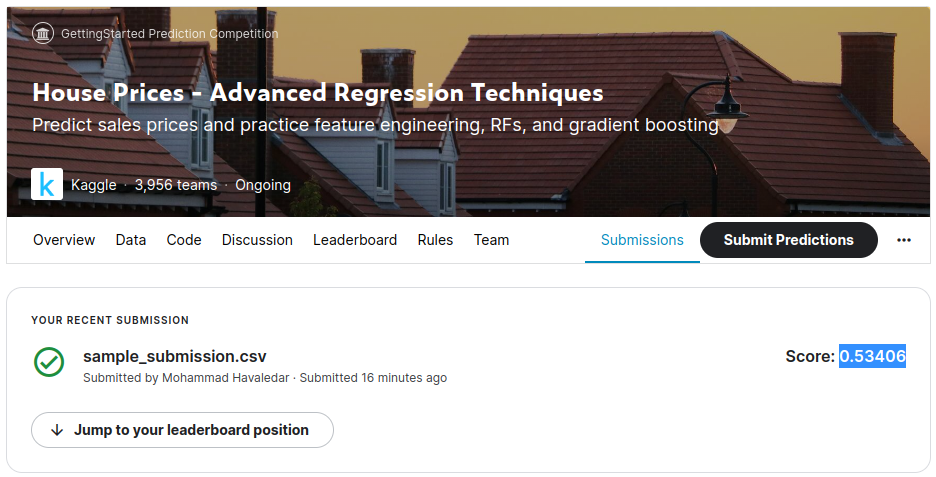

#Ethics


1. The estimation of houses could affect the actual prices houses. The situation become worse when they renovate the house but the database is not updated. So, they request for more price but people rely on the estimate price. In addition, the prices could be estiamted worngly and impacts people to spend more or less money on a hous that does not deserve it.
2. Also, it could bring some concenrs regarding safety of residents. To illustrate, thief can better understand the possibility of wealthier victims and they are able to plan in detail as they know about the very details of the house.
3. Very detailed information of the houses in the database could help compnies take advantage of the information they have to treat customers inquelly. For example, if the capacity of electricity of a city is limited and some residents need electricity subscription, the sun electricity generator could understand which customers has not got a good electricty at home then offer them higher price in comparision to the customers has good electricity.

#Detailed report

Variables with many NA were removed and the others were replaced by the median of the respective columns. 
Categorical columns were converted to number of values minus 1 assuming the first value becomes the base. Then, the NA in this section of variables were filled.
Using a correlation matrix, most related variables were removed. 
The model deployed for 50% test and train subsets several times and the number of best predictors for this model is 86. However, I decided to choose 50 rather than 86. So, based on this number the model was run once more with whole data to find the best model.
Then, test data was converted to the same format of train data and was inputted to the model to predict the sales price.

# Data cleaning

## Loading libraries

In [1]:
#Installation and importing the packages
#Setting options for packages

%%capture

!pip install association_metrics

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm # R-style formula api
import association_metrics as am
import re
from itertools import chain, combinations
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

pd.set_option('precision', 2) # number precision for pandas
pd.set_option('display.max_rows', 12)
pd.set_option('display.max_columns', 12)
pd.set_option('display.float_format', '{:20,.2f}'.format) # get rid of scientific notation

plt.style.use('seaborn') # pretty matplotlib plots

## NA handling


Here I saw that there are NA in the data set and replaced them by median. As NA values exist in categorical columns, get_dummies add one column for them. In this section, I removed those extra sections.

In [2]:
#Importing files from CSV to dataframes
df_train=pd.read_csv("https://raw.githubusercontent.com/havaledar/House-prices-kaggle-6100/main/train.csv")
df_test=pd.read_csv("https://raw.githubusercontent.com/havaledar/House-prices-kaggle-6100/main/test.csv")

In [3]:
#Checking if there are NAs in the database
pd.set_option('display.max_rows', 81)
df_train.isna().sum().to_string(index=False) 

'   0\n   0\n   0\n 259\n   0\n   0\n1369\n   0\n   0\n   0\n   0\n   0\n   0\n   0\n   0\n   0\n   0\n   0\n   0\n   0\n   0\n   0\n   0\n   0\n   0\n   8\n   8\n   0\n   0\n   0\n  37\n  37\n  38\n  37\n   0\n  38\n   0\n   0\n   0\n   0\n   0\n   0\n   1\n   0\n   0\n   0\n   0\n   0\n   0\n   0\n   0\n   0\n   0\n   0\n   0\n   0\n   0\n 690\n  81\n  81\n  81\n   0\n   0\n  81\n  81\n   0\n   0\n   0\n   0\n   0\n   0\n   0\n1453\n1179\n1406\n   0\n   0\n   0\n   0\n   0\n   0'

In [4]:
#Generating dummies for categorical variables
#Removing NA columns generated by get_dummies

df_train_dummy=pd.get_dummies(df_train, dummy_na=True, drop_first=True)

nan_df = df_train_dummy.loc[:, df_train_dummy.columns.str.endswith("_nan")]

pattern = "^([^_]*)_"
regex = re.compile(pattern)

for index in df_train_dummy.index:
    for col_nan in nan_df.columns:
        if df_train_dummy.loc[index,col_nan] == 1:
            col_id = regex.search(col_nan).group(1)
            targets = df_train_dummy.columns[df_train_dummy.columns.str.startswith(col_id+'_')]
            df_train_dummy.loc[index, targets] = np.nan

df_train_dummy.drop(nan_df.columns, axis=1, inplace=True)

In [5]:
# Handling NAs in the database

#Remove the variables with more than 100 NAs
na_number=df_train_dummy[df_train_dummy.columns[df_train_dummy.isnull().any()]].isnull().sum()
df_train_dummy=df_train_dummy.drop(na_number[na_number > 100].index ,axis=1)

# Filling NAs with median
df_train_filled=df_train_dummy.fillna(df_train_dummy.median())
# Check if there is any NA in the dataframe
df_train_filled.isna().sum().max()

0

# Correlation Matrix

I am wondering how I can split the matrix in some smaller matrix as I will miss the correlation between the splitted groups. Becasue of the same reason, if I add more graphs like plotting the scatter plots of variables I cannot split them in groups.

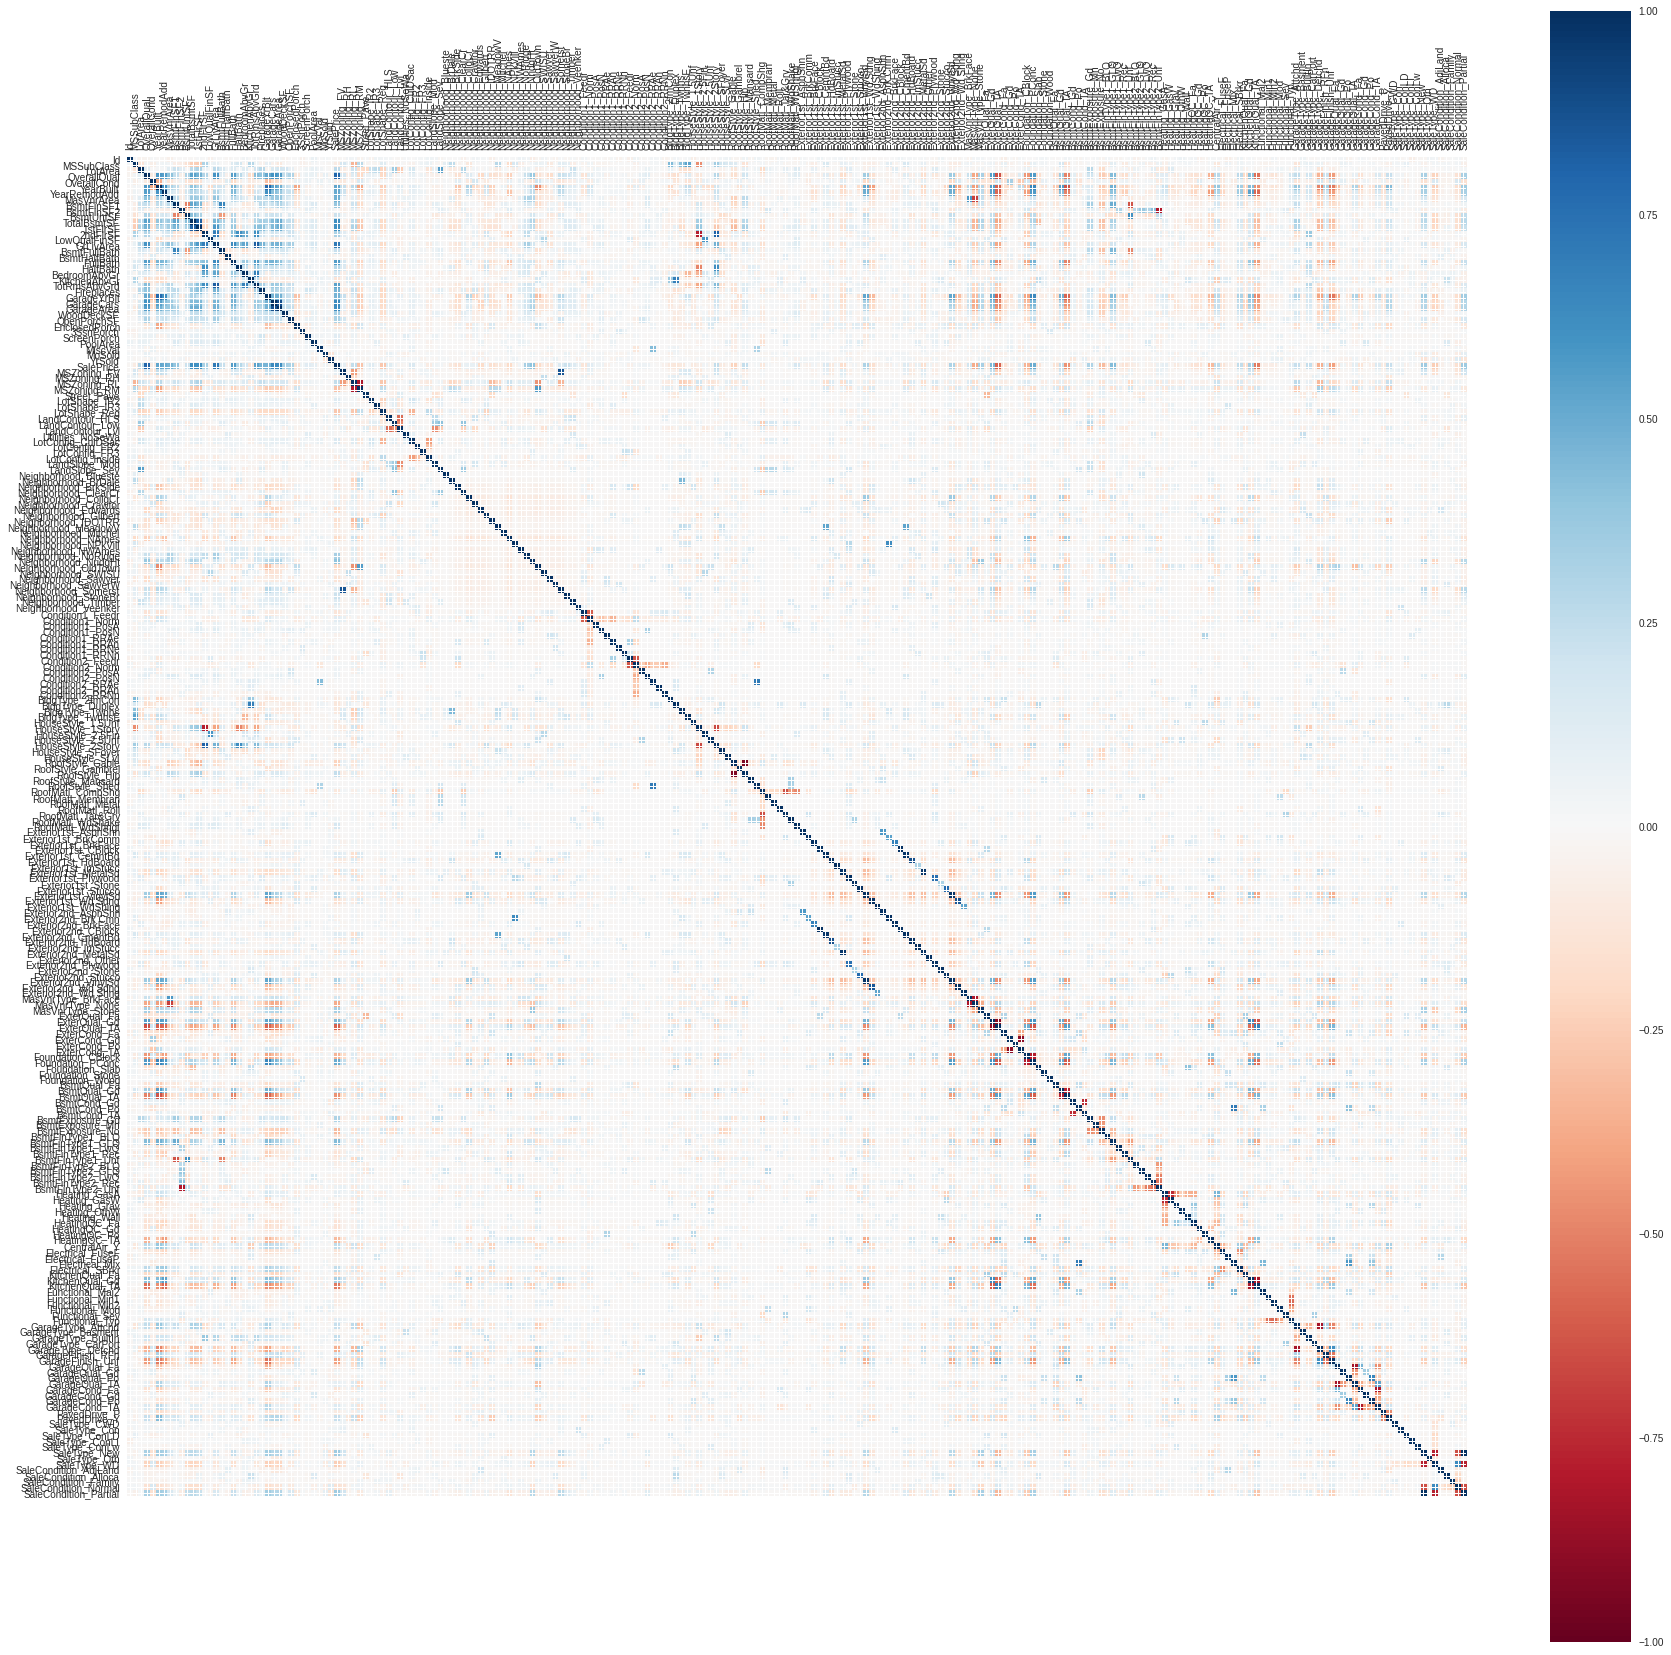

In [6]:
# Plotting the correlation matrix to remove highly correlated variables. 
# As there are many variables it is hard to decide by eye. 

corr = df_train_filled.corr()
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(corr,cmap='RdBu', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(df_train_filled.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(df_train_filled.columns)
ax.set_yticklabels(df_train_filled.columns)
fig.set_size_inches(30, 30)
plt.show()

#todo: why last rows does not appear in the correlation graph and matrix

In [7]:
#Selecting lower triangle without diagonal and removing variables with more than 50% correlations with other predictors

corr=df_train_filled.corr().abs()

corr=corr.where(np.tril(np.ones(corr.shape),-1).astype(np.bool))
corr_50=corr[corr.columns[corr.max()<0.5]]
corr_50

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """


,Id,OverallCond,BsmtFullBath,BsmtHalfBath,Fireplaces,WoodDeckSF,...,SaleType_ConLI,SaleType_ConLw,SaleType_Oth,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family
Id,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN
MSSubClass,0.01,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN
LotArea,0.03,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN
OverallQual,0.03,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN
OverallCond,0.01,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
SaleCondition_AdjLand,0.03,0.04,0.02,0.10,0.05,0.04,...,0.00,0.00,0.00,NaN,NaN,NaN
SaleCondition_Alloca,0.01,0.03,0.07,0.02,0.00,0.00,...,0.01,0.01,0.00,0.00,NaN,NaN
SaleCondition_Family,0.00,0.02,0.04,0.05,0.00,0.01,...,0.01,0.01,0.01,0.01,0.01,NaN
SaleCondition_Normal,0.02,0.16,0.02,0.01,0.02,0.03,...,0.00,0.03,0.10,0.11,0.19,0.25


# Forward selection

## Train and Test sets

The data will be splitted between train and test set.

In [8]:
# Preparing the data for the model

# Splitting dependent and and independent variables in train data
y = df_train_filled["SalePrice"]
X = df_train_filled.loc[:,df_train_filled.columns!="SalePrice"]

y=np.log(y)

# Splitting the train data to train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=3)

## Functions


These two functions helps calculating the RSS and choosing the best one in each category of predictors and proceed with forward selection.

In [9]:
def processSubset(feature_set, X_train, y_train, X_test, y_test):
    # Fit model on feature_set and calculate RSS
    model = sm.OLS(y_train,X_train[list(feature_set)])
    regr = model.fit()
    RSS = ((regr.predict(X_test[list(feature_set)]) - y_test) ** 2).sum()
    return {'features':feature_set, 'model':regr, 'RSS':RSS}

In [10]:
def forward(predictors, X_train, y_train, X_test, y_test):

    # Pull out predictors we still need to process
    remaining_predictors = [p for p in X_train.columns if p not in predictors]
    
    results = []
    
    for p in remaining_predictors:
        results.append(processSubset(predictors+[p], X_train, y_train, X_test, y_test))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    print("----Models:\n----", models['features'],models['RSS'])
    
    # Choose the model with the highest RSS
    best_model = models.loc[models['RSS'].argmin()]
    
    # Return the best model, along with some other useful information about the model
    return best_model

## Train set run



In this section I will check the best amount of predictors with the train set. It takes about 10 minutes.

In [11]:
# Forward selection

%%capture

models_train = pd.DataFrame(columns=['RSS', 'model'])

predictors = []

for i in range(1,len(X.columns)+1):    
    models_train.loc[i] = forward(predictors, X_train, y_train, X_test, y_test)
    predictors = models_train.loc[i]['model'].model.exog_names

# Number of predictors 

RSS amount

Although the minumum of the graphs is 86 however to decrease the amount of over-fitting and also making it easier to process the model, I will choose 50 predictors as after 50 variables the RSS does not change a lot. Using less predictors enables me to interpret the model better. We can see that the amount of RSS do not differ a lot.

The best number of predictors is 86 and the RSS amount is 564070834284.5144.
The selected number of predictors is 50 and the RSS amount is 587518483285.3455.

The best number of predictors is 97 and the RSS amount is 12.103900289467354 .
The selected number of predictors is 50 and the RSS amount is 12.855947422379655 .


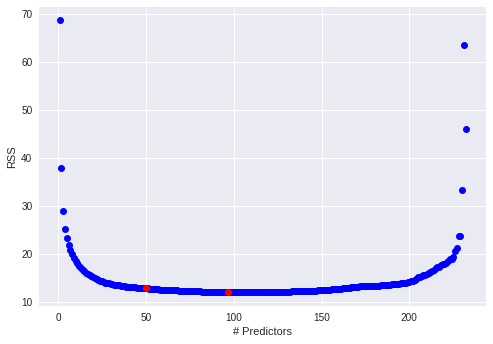

In [12]:
# Plotting the lowest RSS versus number of predictors on test set

plt.plot(models_train['RSS'],'ob')
plt.xlabel('# Predictors')
plt.ylabel('RSS')
plt.plot(models_train['RSS'].argmin(), models_train['RSS'].min(), 'or');
plt.plot(50, models_train.iloc[49, 0] , 'or');

print( "The best number of predictors is", models_train['RSS'].argmin(), "and the RSS amount is", models_train.iloc[85][0], ".")
print( "The selected number of predictors is 50 and the RSS amount is", models_train.iloc[49][0], ".")



## Best predictors

In this section we select the best 50 predictors with train and and full datasets. Although we consider the latter one for the rest of the work as it includes all the data we have to estimate the coefficients.

In [13]:
# Running the model for the whole dataset

%%capture

models_full = pd.DataFrame(columns=['RSS', 'model'])

predictors = []

for i in range(1,len(X.columns)+1):    
    models_full.loc[i] = forward(predictors, X, y, X, y)
    predictors = models_full.loc[i]['model'].model.exog_names

In [14]:
# Printing the predictors in train and whole dataset

print(sorted(models_train.loc[50, 'model'].model.exog_names))

print(sorted(models_full.loc[50, 'model'].model.exog_names))

['BldgType_2fmCon', 'BldgType_Duplex', 'BsmtExposure_Mn', 'BsmtExposure_No', 'BsmtFinType1_Unf', 'BsmtFinType2_BLQ', 'CentralAir_Y', 'Condition1_Norm', 'Condition1_RRAn', 'EnclosedPorch', 'Exterior1st_HdBoard', 'Exterior1st_Stucco', 'Fireplaces', 'Foundation_Slab', 'FullBath', 'Functional_Maj2', 'Functional_Typ', 'GarageCars', 'GarageFinish_Unf', 'GrLivArea', 'Heating_GasW', 'Heating_Grav', 'KitchenAbvGr', 'LotConfig_CulDSac', 'LotShape_IR2', 'MSSubClass', 'MSZoning_FV', 'MSZoning_RL', 'MSZoning_RM', 'Neighborhood_ClearCr', 'Neighborhood_CollgCr', 'Neighborhood_Crawfor', 'Neighborhood_NAmes', 'Neighborhood_NoRidge', 'Neighborhood_NridgHt', 'Neighborhood_SawyerW', 'Neighborhood_Somerst', 'Neighborhood_StoneBr', 'Neighborhood_Timber', 'OverallCond', 'OverallQual', 'RoofMatl_CompShg', 'RoofMatl_WdShngl', 'SaleCondition_Normal', 'SaleType_Con', 'ScreenPorch', 'WoodDeckSF', 'YearBuilt', 'YearRemodAdd', 'YrSold']
['1stFlrSF', 'BldgType_2fmCon', 'BldgType_Twnhs', 'BsmtExposure_Gd', 'BsmtFinTy

## Test set preparation

The same wrangling process as the train set is done for test set so that we can use them in the model appropriately.

In [15]:
#Dummies generated

df_test_dummy=pd.get_dummies(df_test, dummy_na=True, drop_first=True)

# Removing columns generated for NA values

nan_df_test = df_test_dummy.loc[:, df_test_dummy.columns.str.endswith("_nan")]

pattern = "^([^_]*)_"
regex = re.compile(pattern)

for index in df_test_dummy.index:
    for col_nan in nan_df_test.columns:
        if df_test_dummy.loc[index,col_nan] == 1:
            col_id = regex.search(col_nan).group(1)
            targets = df_test_dummy.columns[df_test_dummy.columns.str.startswith(col_id+'_')]
            df_test_dummy.loc[index, targets] = np.nan

df_test_dummy.drop(nan_df_test.columns, axis=1, inplace=True)

#Remove the variables with more than 100 NA
na_number_test=df_test_dummy[df_test_dummy.columns[df_test_dummy.isnull().any()]].isnull().sum()
df_test_dummy=df_test_dummy.drop(na_number_test[na_number_test > 100].index ,axis=1)

# Filling the na with median
df_test_filled=df_test_dummy.fillna(df_test_dummy.median())
df_test_filled.isna().sum().max()

X_test = df_test_filled.loc[:,df_test_filled.columns!="SalePrice"]

# Deploying the model

The amount of categorical variables are considerable in the model meaning that categorical variables paly an important role in estimating the sale price. Also half of the variables do not have signifficant p-value. Most of the variables with meaningful relationship have an either positive or negative ranges which allow us to conclude there is an impact on the sale price. R squared is %98 which is a considerable amount meaning that the predictors cover almost all characteristics of the sale price. Also, it can some how show that our decision regarding choosing 50 rather 86 variables was correct. Although I think the models with 50 variables is not good in case of interpretation.

In [16]:
# Regressing the best model on the test set

best_predictors=sorted(models_full.loc[50, 'model'].model.exog_names)
model_best = sm.OLS(y_train,X_train[best_predictors])
regr_best = model_best.fit()
regr_best.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              SalePrice   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          1.519e+05
Date:                Tue, 25 Oct 2022   Prob (F-statistic):                        0.00
Time:                        00:25:01   Log-Likelihood:                          542.46
No. Observations:                 730   AIC:                                     -986.9
Df Residuals:                     681   BIC:                                     -761.9
Df Model:                          49                                                  
Covariance Type:            nonrobust                                                  
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
1stFlrSF              9.556e-05   2.21e-05      4.325      0.000    5.22e-05       0.000
BldgType_2fmCon         -0.0189      0.044     -0.430      0.668      -0.105       0.067
BldgType_Twnhs          -0.0833      0.030     -2.775      0.006      -0.142      -0.024
BsmtExposure_Gd          0.0831      0.017      4.969      0.000       0.050       0.116
BsmtFinType1_Unf        -0.0348      0.012     -2.786      0.005      -0.059      -0.010
BsmtFullBath             0.0592      0.011      5.477      0.000       0.038       0.080
CentralAir_Y             0.0787      0.023      3.431      0.001       0.034       0.124
Condition1_Norm          0.0520      0.014      3.659      0.000       0.024       0.080
Condition1_PosN          0.0216      0.053      0.408      0.683      -0.082       0.125
Condition2_PosN       4.641e-16   4.12e-16      1.128      0.260   -3.44e-16    1.27e-15
Exterior1st_BrkComm      0.1593      0.135      1.182      0.238      -0.105       0.424
Exterior1st_BrkFace      0.0695      0.025      2.771      0.006       0.020       0.119
Exterior2nd_Stucco       0.0128      0.036      0.354      0.724      -0.058       0.084
Fireplaces               0.0169      0.009      1.931      0.054      -0.000       0.034
Foundation_PConc         0.0415      0.015      2.764      0.006       0.012       0.071
Foundation_Slab         -0.1570      0.036     -4.342      0.000      -0.228      -0.086
FullBath                 0.0182      0.014      1.336      0.182      -0.009       0.045
Functional_Maj2         -0.1588      0.074     -2.135      0.033      -0.305      -0.013
Functional_Sev          -0.3249      0.123     -2.652      0.008      -0.565      -0.084
Functional_Typ           0.0631      0.020      3.082      0.002       0.023       0.103
GarageCars               0.0498      0.009      5.579      0.000       0.032       0.067
GrLivArea                0.0003   2.08e-05     12.947      0.000       0.000       0.000
HalfBath                 0.0166      0.014      1.226      0.220      -0.010       0.043
HeatingQC_TA            -0.0295      0.012     -2.506      0.012      -0.053      -0.006
Heating_GasW             0.0023      0.050      0.046      0.963      -0.095       0.100
Heating_Grav            -0.1843      0.073     -2.534      0.012      -0.327      -0.042
LotArea               2.348e-06   6.27e-07      3.743      0.000    1.12e-06    3.58e-06
LotConfig_CulDSac        0.0443      0.019      2.373      0.018       0.008       0.081
LotShape_IR3            -0.0415      0.082     -0.505      0.614      -0.203       0.120
MSSubClass              -0.0003      0.000     -1.998      0.046      -0.001   -5.99e-06
MSZoning_RH              0.1064      0.045     

## Residual plot
The histogram of residuals seems to be good as it is distributed evenly around 0. As I have got 50 predictors to plot I wanted to plot the residalus versus y rather than every predictors but I was not able to to so. So, I only plotted it for the first variable which shome how shows a satisfying (not perfect) distribution for a linear model of this problem. 

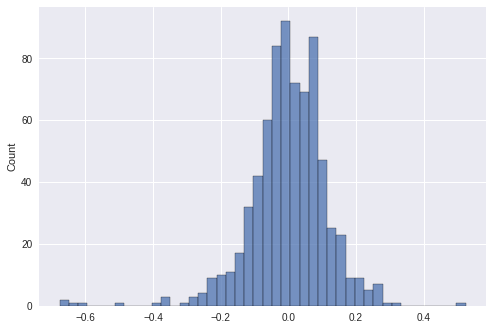

In [17]:
sns.histplot(regr_best.resid)

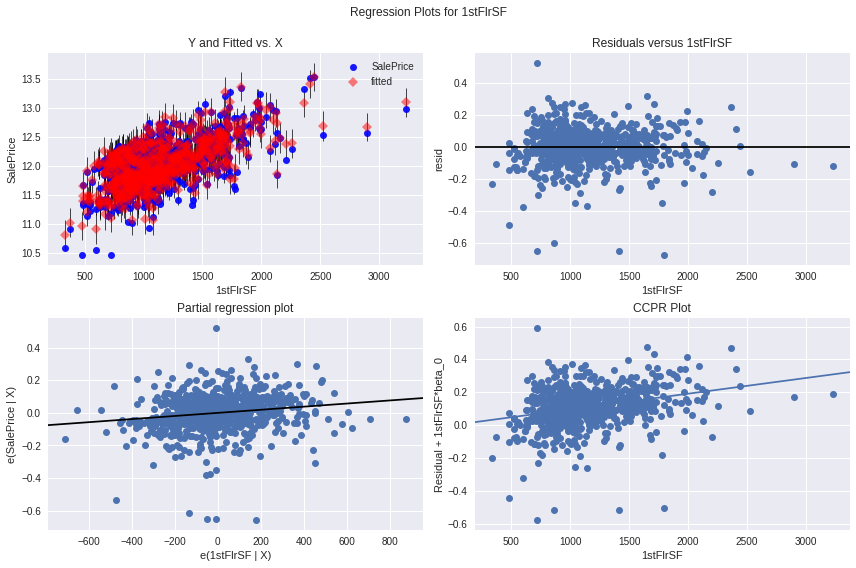

In [18]:
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_regress_exog(regr_best, "1stFlrSF", fig=fig)

# Prediction

In [19]:
# Predicting the sale price for the test set

#best_pre_0 = [e for e in best_predictors if e not in ('Heating_OthW', 'RoofMatl_CompShg', 'RoofMatl_Membran', 'RoofMatl_Metal', 'RoofMatl_Roll')]
#X_test_1=X_test[best_pre_0]
#X_test_1['Heating_OthW'], X_test_1['RoofMatl_CompShg'], X_test_1['RoofMatl_Membran'], X_test_1['RoofMatl_Metal'], X_test_1['RoofMatl_Roll']=[0,0,0,0,0]

predictions = regr_best.predict(X_test[best_predictors])

predictions

0                     11.68
1                     11.90
2                     12.07
3                     12.16
4                     12.26
               ...         
1454                  11.40
1455                  11.38
1456                  11.93
1457                  11.67
1458                  12.32
Length: 1459, dtype: float64

In [23]:
from math import exp
pred=predictions.to_frame()
pred.index.names = ['Id']
pred.index += 1461 
pred.columns=["SalePrice"]
pred["SalePrice"]=np.exp(pred["SalePrice"])
pred.to_csv("sub.csv")

I think something is not precise. It seems to me if I take log of sale price, then I should use exp of so that I can interpret the amounts. While when I do it all predictions becomes infinite.



